d# Are ILO green transition scenarios consistent with occupational greenness levels?
Felix Zaussinger | 27.05.2021

## Core Analysis Goal(s)
1. Assess whether the two data sources (ILO Green Transition Scenarios and ONET
greenness scores) are consistent

## Key Insight(s)
1. They are not consistent: greenness scores do not correlate with net job
creation

In [1]:
import os
import sys
import logging
from pathlib import Path

import numpy as np
import scipy as sp
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.iolib.summary2 import summary_col
from stargazer.stargazer import Stargazer
from scipy.stats import kendalltau, pearsonr, spearmanr

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_context("paper")
sns.set(rc={'figure.figsize': (16, 9.)})
sns.set_style("ticks")

import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

logging.basicConfig(level=logging.INFO, stream=sys.stdout)

Define directory structure

In [2]:
# project directory
abspath = os.path.abspath('')
project_dir = str(Path(abspath).parents[0])

# sub-directories
data_raw = os.path.join(project_dir, "data", "raw")
data_interim = os.path.join(project_dir, "data", "interim")
data_processed = os.path.join(project_dir, "data", "processed")
figure_dir = os.path.join(project_dir, "reports", "figures")

Code ...

In [3]:
df = pd.read_csv(
    os.path.join(data_interim, "ESCO_ONET_METADATA.csv"),
    index_col=0
)

n_green_occ = df.shape[0] - df.greenness_vona_2018_v2.isna().sum()

df.greenness_vona_2018_v2 = df.greenness_vona_2018_v2.fillna(0)

# convert job zone to categorical var
df.job_zone = pd.Categorical(df.job_zone, ordered=True)

Correlation matrix of all numeric variables

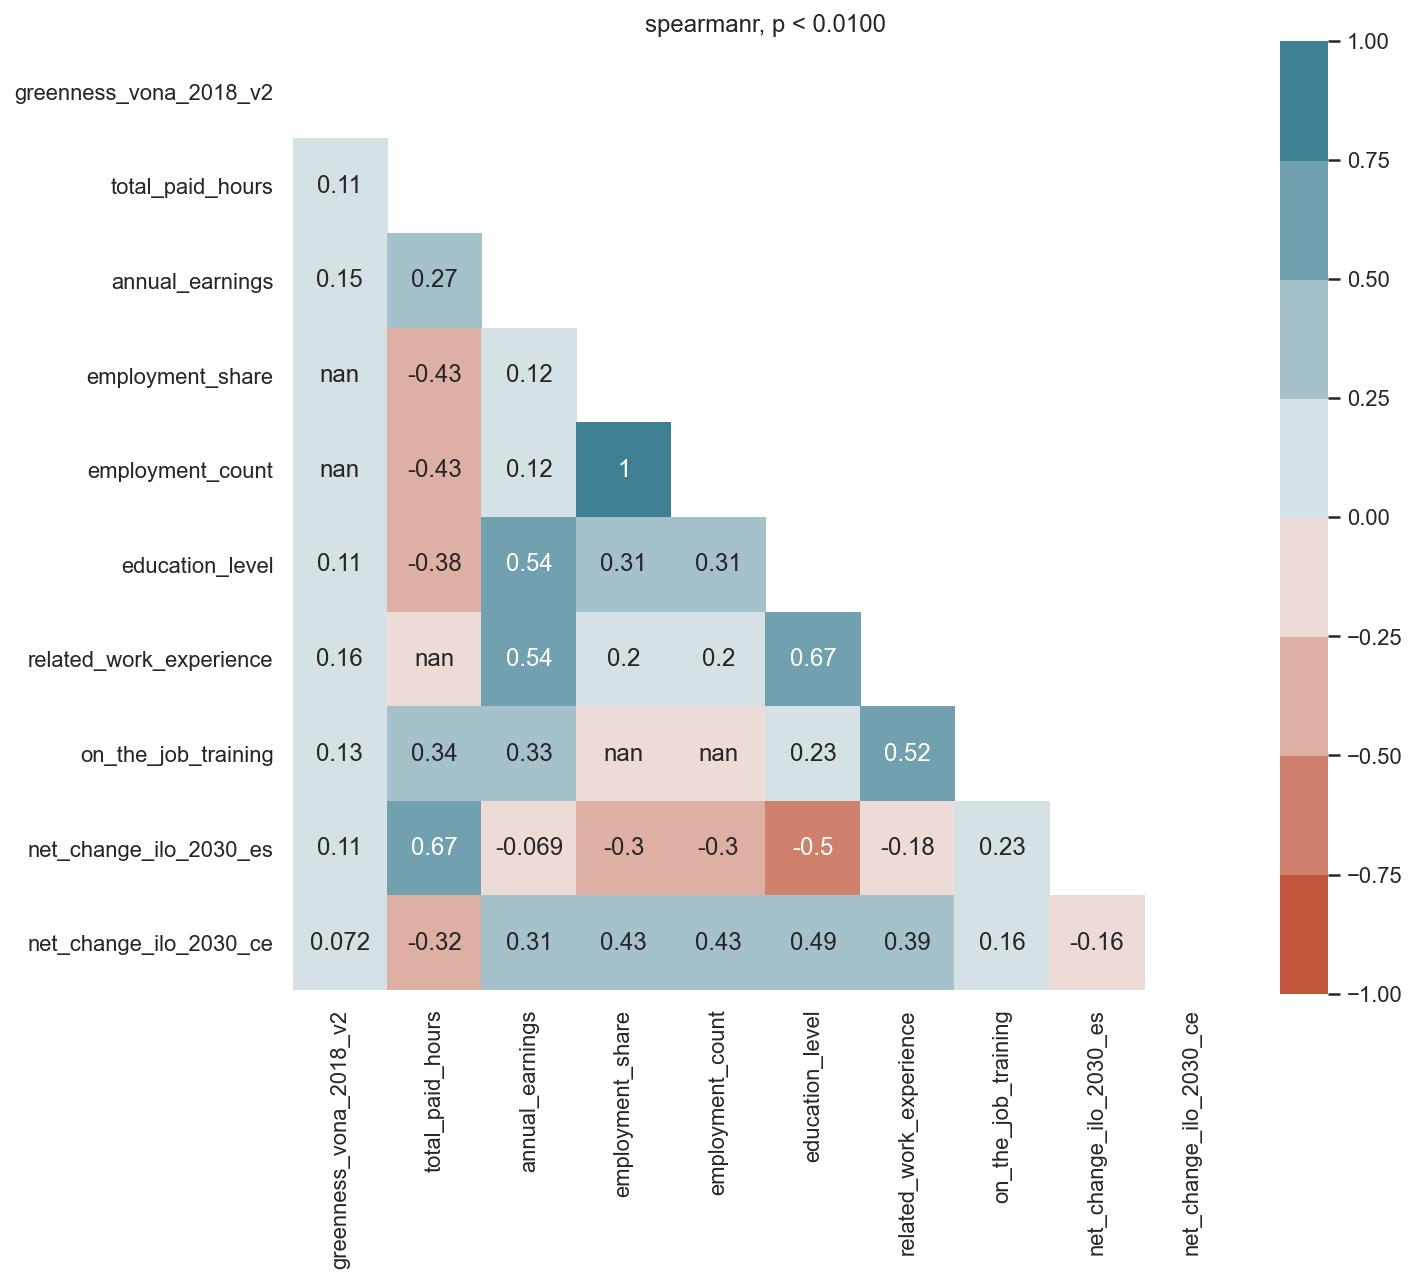

In [14]:
from src.visualization.visualize import correlation_matrix_plot

cols_numeric = [
    'greenness_vona_2018_v2', 'total_paid_hours',
    'annual_earnings', 'employment_share', 'employment_count', 'job_zone',
    'education_level', 'related_work_experience', 'on_the_job_training',
    'net_change_ilo_2030_es', 'net_change_ilo_2030_ce'
]

correlation_matrix_plot(
    df=df[cols_numeric],
    significance_level=0.01,
    figsize=(10, 10),
    function=spearmanr
)

plt.savefig(
    os.path.join(figure_dir, "corr_mat_spearmanr_covariates_isco04.png"),
    dpi=150
)

### Regress greenness on covariates

Job Zones:

    Job Zone 1 - occupations that need little or no preparation
    Job Zone 2 - occupations that need some preparation
    Job Zone 3 - occupations that need medium preparation
    Job Zone 4 - occupations that need considerable preparation
    Job Zone 5 - occupations that need extensive preparation


In [5]:
df.columns

Index(['id', 'concept_uri', 'preferred_label', 'isco_level_4', 'onet_code',
       'onet_occupation', 'isco_level_1', 'isco_level_2', 'isco_level_3',
       'occupation_type', 'n_new_green_tasks', 'n_existing_green_tasks',
       'n_non_green_tasks', 'greenness_vona_2018', 'greenness_vona_2018_v2',
       'total_paid_hours', 'annual_earnings', 'employment_share',
       'employment_count', 'job_zone', 'education_level',
       'related_work_experience', 'on_the_job_training', 'skill_level_ilo',
       'new_jobs_absorbing_ilo_2030_es', 'new_jobs_net_ilo_2030_es',
       'jobs_lost_net_ilo_2030_es', 'jobs_lost_reallocated_ilo_2030_es',
       'net_change_ilo_2030_es', 'new_jobs_absorbing_ilo_2030_ce',
       'new_jobs_net_ilo_2030_ce', 'jobs_lost_net_ilo_2030_ce',
       'jobs_lost_reallocated_ilo_2030_ce', 'net_change_ilo_2030_ce'],
      dtype='object')

In [6]:
reg_greenness = ols(
    formula="greenness_vona_2018_v2 ~ education_level + on_the_job_training + related_work_experience + total_paid_hours + annual_earnings + C(job_zone)",
    data=df
).fit(cov_type='HC3')

Stargazer([reg_greenness])

In [7]:
# aggregate at isco 2-digit level

cols = ["isco_level_2", "greenness_vona_2018_v2", "net_change_ilo_2030_es", "net_change_ilo_2030_ce"]

df_sub = df[cols]

df_isco2 = df_sub.groupby("isco_level_2").mean()

df_isco2.corr()

,greenness_vona_2018_v2,net_change_ilo_2030_es,net_change_ilo_2030_ce
greenness_vona_2018_v2,1.000000,0.175286,0.028990
net_change_ilo_2030_es,0.175286,1.000000,-0.275835
net_change_ilo_2030_ce,0.028990,-0.275835,1.000000


<AxesSubplot:xlabel='isco_level_2'>

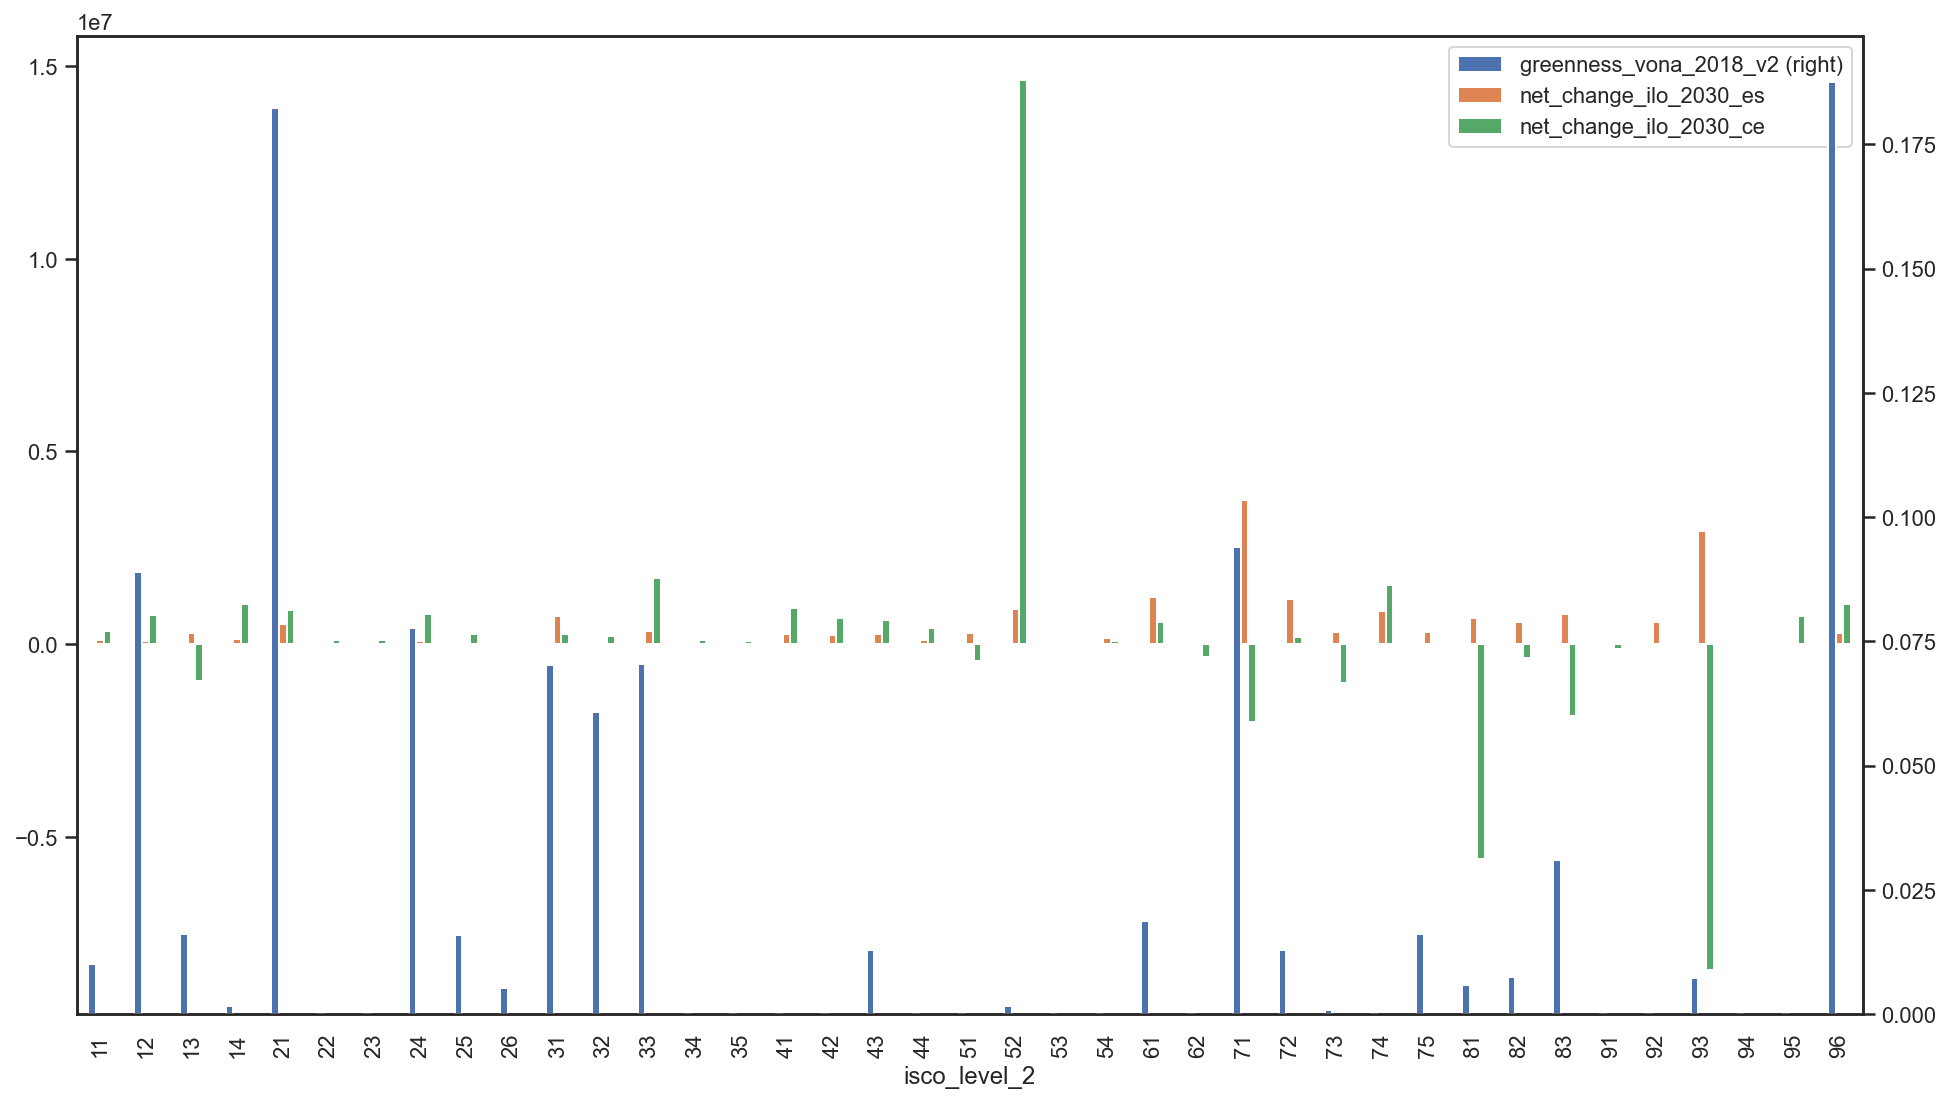

In [8]:
df_isco2.plot.bar(secondary_y="greenness_vona_2018_v2")

In [21]:
# fit regressions
m1 = ols(
    formula="net_change_ilo_2030_es ~ greenness_vona_2018_v2",
    data=df_isco2
)

m2 = ols(
    formula="net_change_ilo_2030_ce ~ greenness_vona_2018_v2",
    data=df_isco2
)

reg1 = m1.fit()
reg2 = m2.fit()

# regression summary table
stargazer = Stargazer([reg1, reg2])
stargazer.custom_columns(['Employment Change (Energy Sustainability)', 'Employment Change (Circular Economy)'], [1, 1])
#stargazer.render_html()
stargazer

In [19]:
# same at granular level but with isco 2-digit dummies

# fit regressions
m1 = ols(
    formula="net_change_ilo_2030_es ~ greenness_vona_2018_v2 + C(isco_level_2)",
    data=df
)

m2 = ols(
    formula="net_change_ilo_2030_ce ~ greenness_vona_2018_v2 + C(isco_level_2)",
    data=df
)

reg1 = m1.fit()
reg2 = m2.fit()

# regression summary table
stargazer = Stargazer([reg1, reg2])
stargazer.custom_columns(['Employment Change (Energy Sustainability)', 'Employment Change (Circular Economy)'], [1, 1])
stargazer.show_model_numbers(False)
#stargazer.significant_digits(2)
stargazer.significance_levels([0.05, 0.01, 0.001])
stargazer.rename_covariates(
    {'greenness_vona_2018_v2': 'Greenness', 'isco_level_2': 'ISCO 2-digit dummy'}
)
stargazer.add_custom_notes(['Greenness refers to the ratio of the number of green tasks over all tasks and was calculated based on O*NET data according to Vona et al. (2018).'])
stargazer

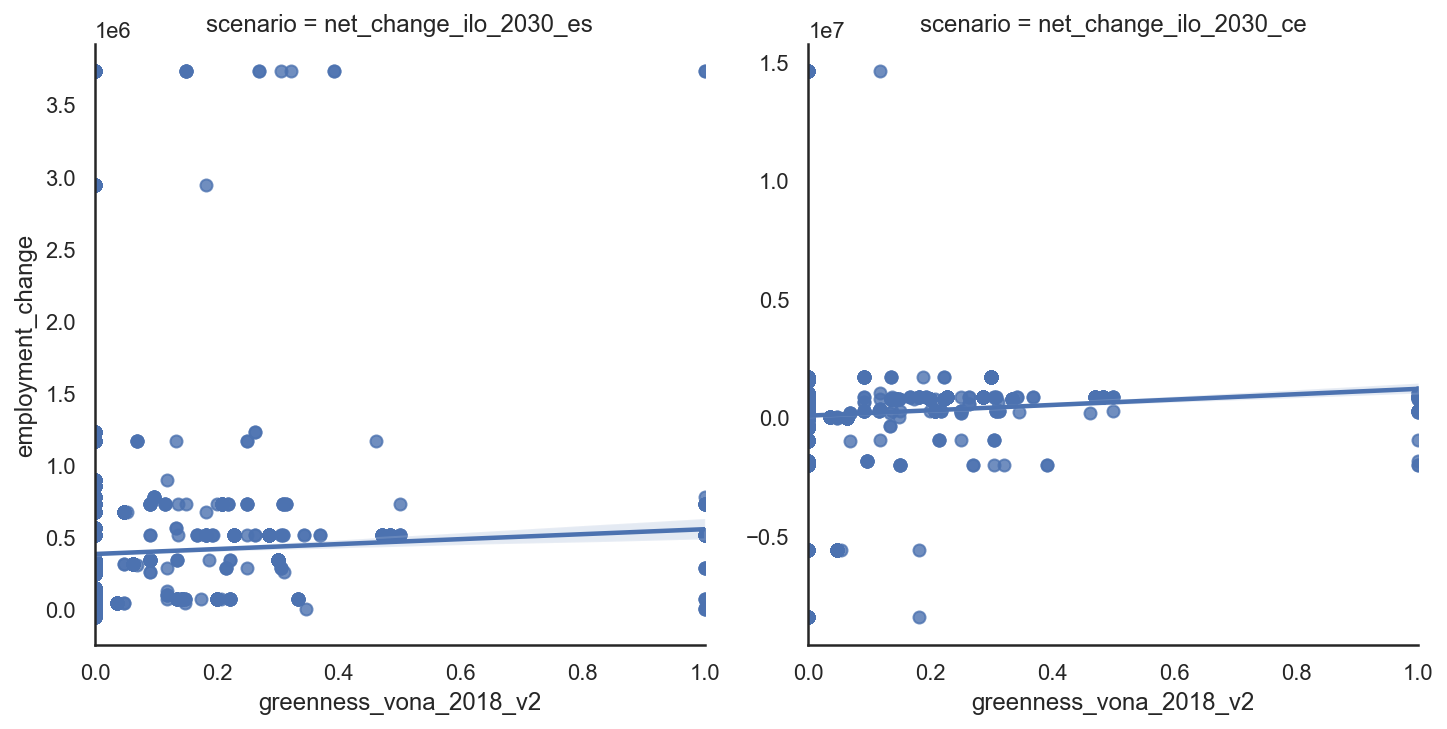

In [20]:
df_melted = df[["greenness_vona_2018_v2", "net_change_ilo_2030_es", "net_change_ilo_2030_ce"]].melt(
    id_vars=['greenness_vona_2018_v2'],
    value_vars=['net_change_ilo_2030_es', 'net_change_ilo_2030_ce'],
    var_name='scenario', value_name='employment_change'
)

sns.lmplot(
    x="greenness_vona_2018_v2",
    y="employment_change",
    col="scenario",
    sharey=False,
    robust=True,
    data=df_melted
)

plt.savefig(
    os.path.join(figure_dir, "greenness_regressions.png"),
    dpi=150
)